# ```asammdf``` Quick Start & Reference.

A one page introduction to ```asammdf``` for Measurement Data Format (MDF) data analysis.

For engineers wanting to drink from a fire hose or already experienced with Python data analysis.

Replaces some or all of the functionality of these tools with a fullly opensource, free, analysis stack:

- [AVL CONCERTO 5™](https://www.avl.com/web/guest/-/avl-concerto-5-)
- [MathWorks® Vehicle Network Toolbox™](https://www.mathworks.com/products/vehicle-network.html)
- [ETAS Measure Data Analyzer (MDA V8)](https://www.etas.com/en/company/realtimes_2019_2020-quick-and-intuitive-analysis-of-measurement-data.php)
- [National Instruments DIAdem](https://www.ni.com/en-us/shop/data-acquisition-and-control/application-software-for-data-acquisition-and-control-category/what-is-diadem.html)
- [Vector CANape & vSignalyzer](https://www.vector.com/int/en/products/application-areas/ecu-calibration/analyzing-evaluating-measurement-data/)

In [1]:
%matplotlib inline
import asammdf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Create MDF File

- Create a [0, 10)s time vector with 100Hz sampling rate (10 ms raster)
- Create a simple MDF file with two channels:
    - "EngineSpeedCmd" 0.5 Hz sinewave with amplitude=10, & dc offset=600.
    - "EngineSpeed" 0.5 Hz sinewave with amplitude=5, phi=pi/8, & dc offset=600.


### Generate Engine Speed signals

In [37]:
# Time Vector
t0=0  # [s]
tf=10 # [s]
f_sample = 100 # [Hz]
dT = 1/f_sample # [s]
timestamps = np.arange(t0, tf, dT)
# Engine Speed
A = 10
f_signal = 0.5
dc_offset = 600
engine_speed_cmd = A*np.sin(2*np.pi*f_signal*timestamps)+dc_offset
engine_speed = A*0.5*np.sin(2*np.pi*f_signal*(timestamps-0.25))+dc_offset

### Plot engine speed signal.

Direct plotting with [matplotlib](https://matplotlib.org/) & [seaborn](https://seaborn.pydata.org/).

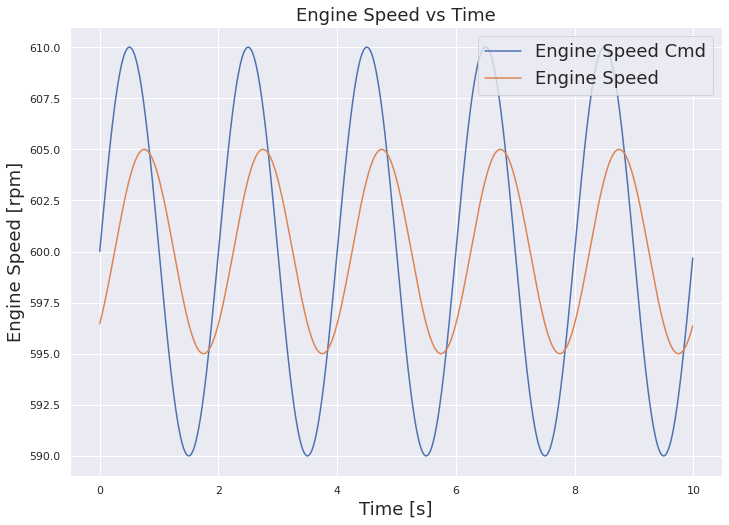

In [38]:
sns.set(
    rc={
        "figure.figsize": (11.69, 8.27), # A4 paper size.
        "figure.facecolor": "w",
        "figure.edgecolor": "k",
        "axes.labelsize": 18,
        "axes.titlesize": 18,
        "legend.fontsize": 18,
    }
)
plt.plot(timestamps, engine_speed_cmd, timestamps, engine_speed)
plt.xlabel("Time [s]")
plt.ylabel("Engine Speed [rpm]")
plt.title("Engine Speed vs Time")
plt.legend(
    {"Engine Speed Cmd", "Engine Speed"},
    loc='upper right'
);
plt.savefig(
    "EngineSpeedPlot.png",
    transparent=False,
    bbox_inches='tight'
);

## Generate ```asammdf```.```Signal``` & save ```MDF``` file.

Convert the ```numpy``` arrays into ```asammdf.Signal```s & save.

### ```Signal``` Object

In [39]:
asammdf.Signal?

In [109]:
engine_speed_cmd_sig = asammdf.Signal(
    samples=engine_speed_cmd,
    timestamps=timestamps,
    unit='rpm',
    name='EngineSpeedCmd',
    conversion=None,
    comment='Swept sine plant identification, X(t)',
    raw=True,
    master_metadata=None,
    display_name='Engine Speed Command',
    attachment=(),
    source=None,
    bit_count=None,
    stream_sync=False,
    invalidation_bits=None,
    encoding=None,
)
engine_speed_sig = asammdf.Signal(
    samples=engine_speed,
    timestamps=timestamps,
    unit='rpm',
    name='EngineSpeed',
    conversion=None,
    comment='Swept sine plant identification, Y(t)',
    raw=True,
    master_metadata=None,
    display_name='Engine Speed',
    attachment=(),
    source=None,
    bit_count=None,
    stream_sync=False,
    invalidation_bits=None,
    encoding=None,
)
signals = [
    engine_speed_cmd_sig,
    engine_speed_sig,
]

### ```MDF``` Object

In [110]:
asammdf.MDF?

Write the file directly in and out of a context manager.

In [111]:
with asammdf.MDF(version="4.10") as mdf:
    mdf.append(signals, "Created by Python") 
    # save new file
    mdf.save("quickstart_example.mf4", overwrite=True)

In [112]:
mdf = asammdf.MDF(version="4.10")
mdf.append(signals, "Created by Python") 
    # save new file
mdf.save("quickstart_example.mf4", overwrite=True)
mdf.close()

```fsspec``` example.

> Filesystem Spec is a project to unify various projects and classes to work with remote filesystems and file-system-like abstractions using a standard pythonic interface.
> - https://filesystem-spec.readthedocs.io/en/latest/

This allows reading & writing directly from S3, Azure Datalakes, Google Storage, and others.

In [113]:
import fsspec
with fsspec.open("quickstart_example_fs.mf4", "wb") as fid:
    with asammdf.MDF(version="4.10") as mdf:
        mdf.append(signals, "Created by Python") 
        # save new file
        mdf.save(fid, overwrite=True)

# Read & Analyze MDF


In [114]:
%matplotlib inline
import asammdf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Open a file with and without ```fsspec```.

In [115]:
with fsspec.open("quickstart_example_fs.mf4", "rb") as fid:
    mdf = asammdf.MDF(fid)

In [116]:
mdf = asammdf.MDF("quickstart_example.mf4")

List the channels in the database.

In [117]:
mdf.channels_db

{'time': ((0, 0),), 'EngineSpeedCmd': ((0, 1),), 'EngineSpeed': ((0, 2),)}

In [118]:
mdf.get_channel_unit("EngineSpeedCmd")

'rpm'

In [119]:
mdf.get_channel_comment("EngineSpeedCmd")

'Swept sine plant identification, X(t)'

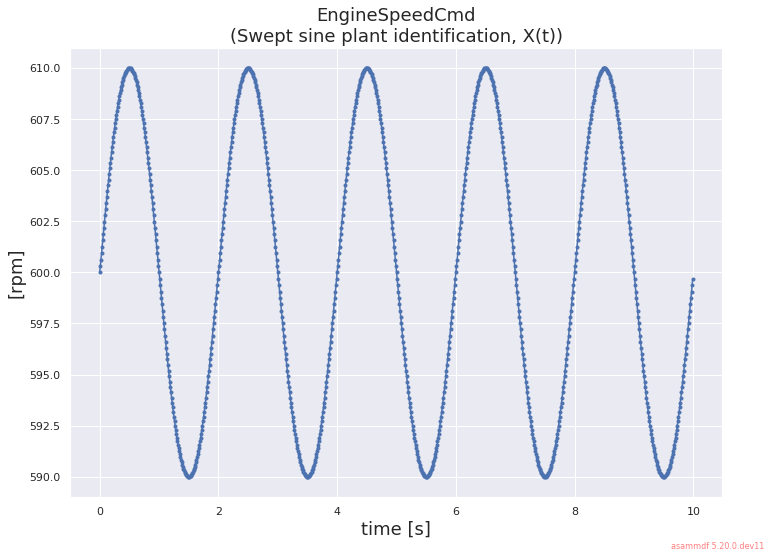

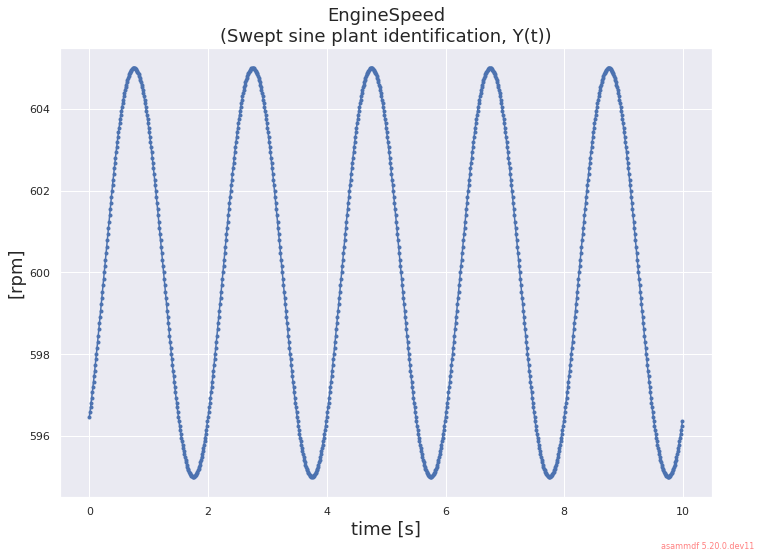

In [121]:
sns.set(
    rc={
        "figure.figsize": (11.69, 8.27), # A4 paper size.
        "figure.facecolor": "w",
        "figure.edgecolor": "k",
        "axes.labelsize": 18,
        "axes.titlesize": 18,
        "legend.fontsize": 18,
    }
)
for channel in mdf.iter_channels():
    channel.plot()

### Export to [```pandas```.```DataFrame```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html):

In [149]:
df = mdf.to_dataframe()

In [150]:
df.describe()

,EngineSpeedCmd,EngineSpeed
count,1000.000000,1000.000000
mean,600.000000,600.000000
std,7.074606,3.537303
min,590.000000,595.000000
25%,592.928932,596.464466
50%,600.000000,600.000000
75%,607.071068,603.535534
max,610.000000,605.000000


In [151]:
df

,EngineSpeedCmd,EngineSpeed
timestamps,,
0.00,600.000000,596.464466
0.01,600.314108,596.577264
0.02,600.627905,596.693441
0.03,600.941083,596.812880
0.04,601.253332,596.935465
...,...,...
9.95,598.435655,595.954915
9.96,598.746668,596.049225
9.97,599.058917,596.147434


Reset Index

Convert the 'timestamps' index back into a column for direct plotting from ```pandas```.

In [154]:
# Convert the 
df.reset_index(inplace=True)

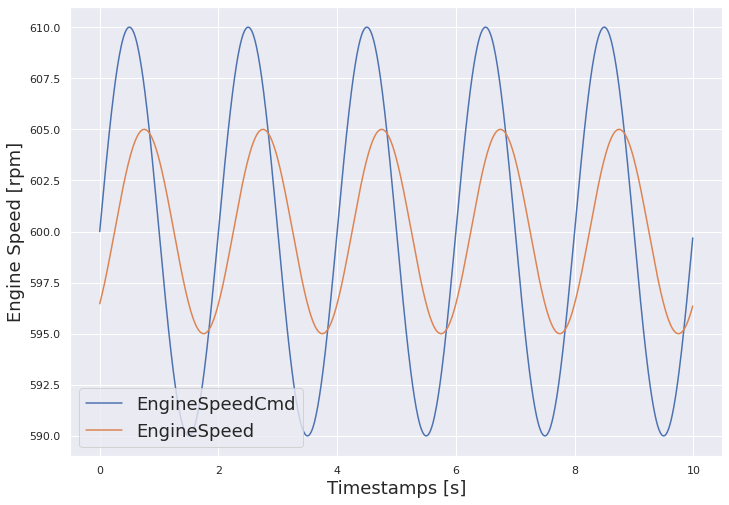

In [158]:
df.plot(x="timestamps", y={"EngineSpeed", "EngineSpeedCmd"})
plt.ylabel("Engine Speed [rpm]")
plt.xlabel("Timestamps [s]");

# Export

```asammdf``` natively supports:

- csv
- hdf5
- mat
- parquet

In [164]:
mdf.export?

In [169]:
mdf.export(fmt="csv")
!ls *.csv

quickstart_example.ChannelGroup_0.csv


In [170]:
pd.read_csv("quickstart_example.ChannelGroup_0.csv")

,timestamps,EngineSpeedCmd,EngineSpeed
0,0.00,600.000000,596.464466
1,0.01,600.314108,596.577264
2,0.02,600.627905,596.693441
3,0.03,600.941083,596.812880
4,0.04,601.253332,596.935465
...,...,...,...
995,9.95,598.435655,595.954915
996,9.96,598.746668,596.049225
997,9.97,599.058917,596.147434
998,9.98,599.372095,596.249445


In [171]:
mdf.export(fmt="hdf5")
!ls *.hdf

quickstart_example.hdf


In [172]:
mdf.export(fmt="mat")
!ls *.mat

quickstart_example.mat
